In [1]:
import pandas as pd

# 데이터 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')
# 전처리
# 훈련 및 테스트 세트 모두에서 'ID' 열을 삭제하세요. 학습에 불필요한 칼럼입니다.
train = train.drop(['ID'], axis = 1)
test = test.drop(['ID'],axis = 1)

mean_value = train['SkinThickness'][train['SkinThickness'] != 0].mean()
# train['SkinThickness'] = train['SkinThickness'].replace(0, mean_value)
# train['Q1'] = 0
# train.loc[(train['DiabetesPedigreeFunction'] > 0.8), 'Q1'] = 1

mean_value1 = test['SkinThickness'][test['SkinThickness'] != 0].mean()
# test['SkinThickness'] = test['SkinThickness'].replace(0, mean_value1)
# test['Q1'] = 0

# mean_value1 = train['Insulin'][train['Insulin'] != 0].mean()
# train['Insulin'] = train['Insulin'].replace(0, mean_value1)

# Train set을 독립변수(X)와 종속변수(y)로 나누세요
X = train.drop('Outcome', axis =1)
y = train['Outcome']
# sklearn의 train_test_split을 사용하여 Train set와 Test set으로 분할하세요
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3)

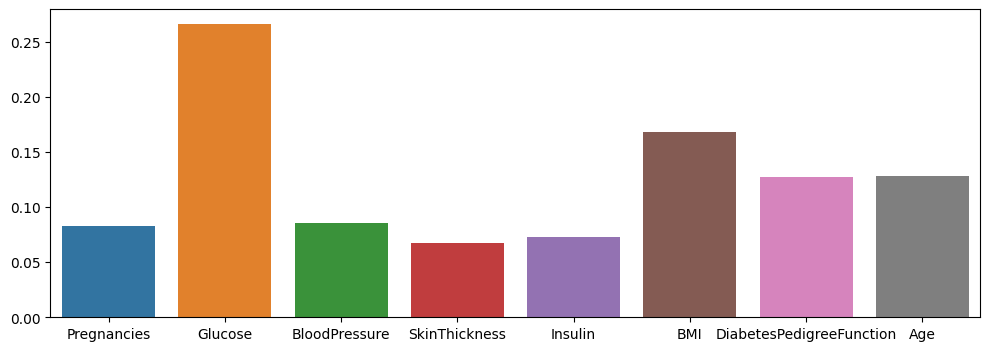

In [2]:
# Randomforest 로 피쳐중요도 확인
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

features = train.columns[:-1]
train_x = train[features]
train_y = train['Outcome']

RF_model = RandomForestClassifier(random_state = 42)
RF_model.fit(train_x,train_y)
importances = RF_model.feature_importances_
feature_names = RF_model.feature_names_in_
plt.figure(figsize=(12,4))
sns.barplot(x=feature_names, y= importances)
plt.show()


```
importances = RF_model.feature_importances_
feature_names = RF_model.feature_names_in_
이라는 속성이용해서 작성
```

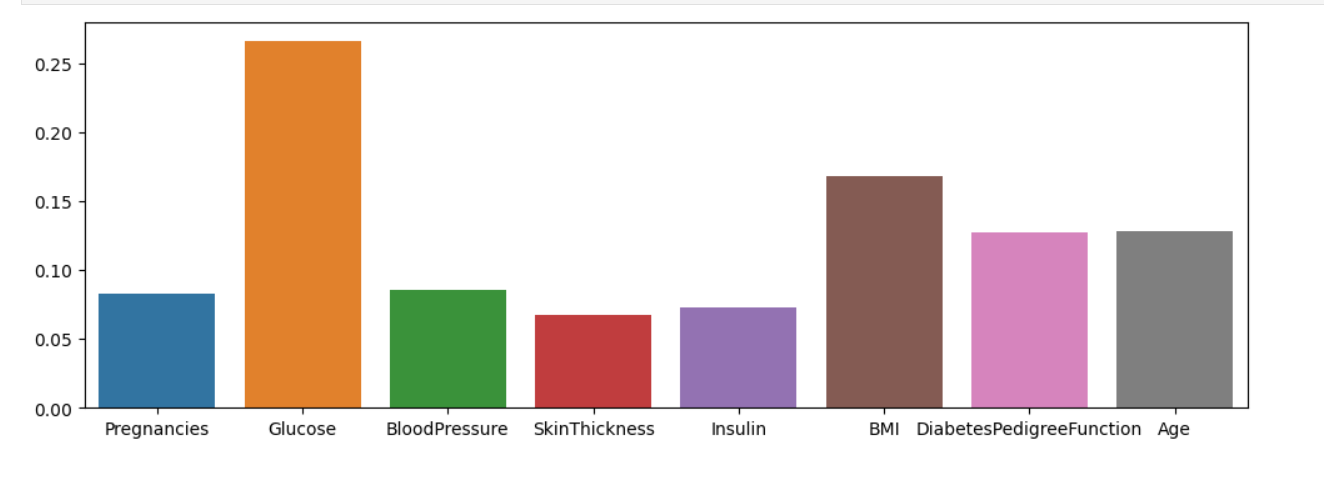

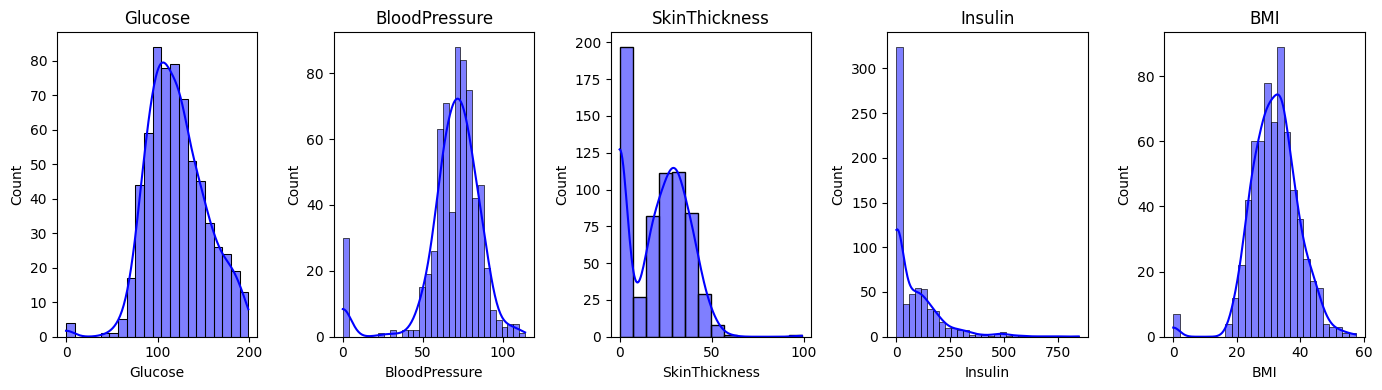

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


features = ['Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI' ]

plt.figure(figsize=(14,4))

for idx, feature in enumerate(features):
  ax1 = plt.subplot(1,5,idx+1)
  plt.title(feature)
  plt.tight_layout()
  sns.histplot(x=feature, data = train, color = 'blue', kde=True)

plt.show()

In [4]:
features_to_check = ['SkinThickness', 'Insulin', 'Glucose', 'BMI', 'BloodPressure']

for feature in features_to_check:
    n_missing = len(train[train[feature] == 0])
    ratio_missing = round(n_missing / len(train) * 100.0, 1)
    print(f"{feature} 결측치 갯수 : {n_missing}/{len(train)} ({ratio_missing})%")

SkinThickness 결측치 갯수 : 195/652 (29.9)%
Insulin 결측치 갯수 : 318/652 (48.8)%
Glucose 결측치 갯수 : 4/652 (0.6)%
BMI 결측치 갯수 : 7/652 (1.1)%
BloodPressure 결측치 갯수 : 30/652 (4.6)%


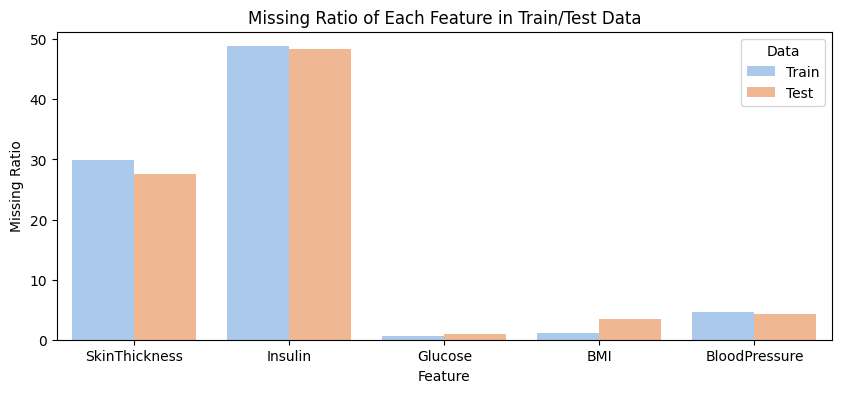

In [5]:
# seaborn의 색상 팔레트를 변경합니다.
sns.set_palette('pastel')

# Train 데이터의 결측치 비율을 계산합니다.
missing_ratio_train = []
for feature in features_to_check:
    n_missing = len(train[train[feature] == 0])
    ratio_missing = round(n_missing / len(train) * 100.0, 1)
    missing_ratio_train.append(ratio_missing)

# Test 데이터의 결측치 비율을 계산합니다.
missing_ratio_test = []
for feature in features_to_check:
    n_missing = len(test[test[feature] == 0])
    ratio_missing = round(n_missing / len(test) * 100.0, 1)
    missing_ratio_test.append(ratio_missing)

# 각각의 데이터프레임으로 변환합니다.
missing_df_train = pd.DataFrame({'Feature': features_to_check, 'Missing Ratio': missing_ratio_train, 'Data': 'Train'})
missing_df_test = pd.DataFrame({'Feature': features_to_check, 'Missing Ratio': missing_ratio_test, 'Data': 'Test'})

# 두 데이터프레임을 합쳐서 새로운 데이터프레임을 만듭니다.
missing_df = pd.concat([missing_df_train, missing_df_test])

# 시각화를 합니다.
plt.figure(figsize=(10, 4))
sns.barplot(x='Feature', y='Missing Ratio', hue='Data', data=missing_df)
plt.title('Missing Ratio of Each Feature in Train/Test Data')
plt.show()

,Feature,Missing Insulin,Normal Insulin
0,SkinThickness,0.000000,61.320755
1,Glucose,0.299401,0.943396
2,BMI,0.299401,1.886792
3,BloodPressure,0.000000,9.433962


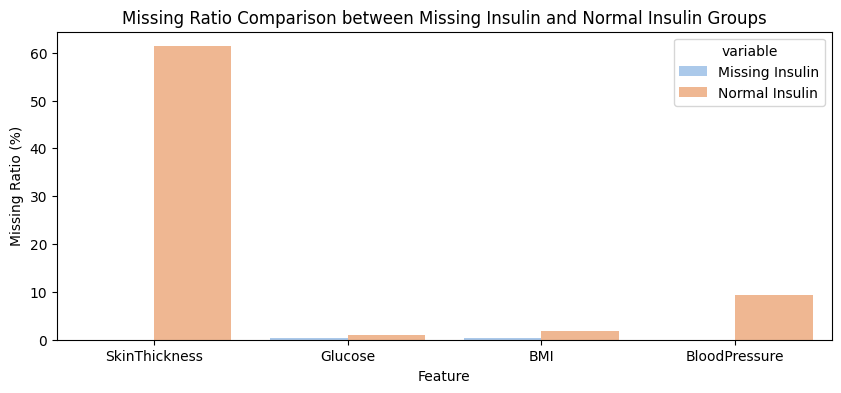

In [6]:
# 'Insulin'이 결측치인 데이터와 결측치가 아닌 데이터를 분리
train_missing_insulin = train[train['Insulin'] != 0]
train_normal_insulin = train[train['Insulin'] == 0]

# 'Insulin'을 제외한 피처 리스트
features_to_check = ['SkinThickness', 'Glucose', 'BMI', 'BloodPressure']


# 각 데이터 프레임에 대한 결측치 비율 계산
missing_insulin_ratios = [len(train_missing_insulin[train_missing_insulin[feature] == 0]) / len(train_missing_insulin) * 100.0 for feature in features_to_check]
normal_insulin_ratios = [len(train_normal_insulin[train_normal_insulin[feature] == 0]) / len(train_normal_insulin) * 100.0 for feature in features_to_check]

# 데이터 프레임 생성
df_missing_ratios = pd.DataFrame({
    'Feature': features_to_check,
    'Missing Insulin':missing_insulin_ratios,
    'Normal Insulin': normal_insulin_ratios
})

display(df_missing_ratios)

# 데이터 프레임을 긴 형식(long format)으로 변경
df_missing_ratios_melted = df_missing_ratios.melt(id_vars='Feature', value_vars=['Missing Insulin', 'Normal Insulin'])

# 시각화
plt.figure(figsize=(10, 4))
sns.barplot(x='Feature', y='value', hue='variable', data=df_missing_ratios_melted)
plt.ylabel('Missing Ratio (%)')
plt.title('Missing Ratio Comparison between Missing Insulin and Normal Insulin Groups')
plt.show()

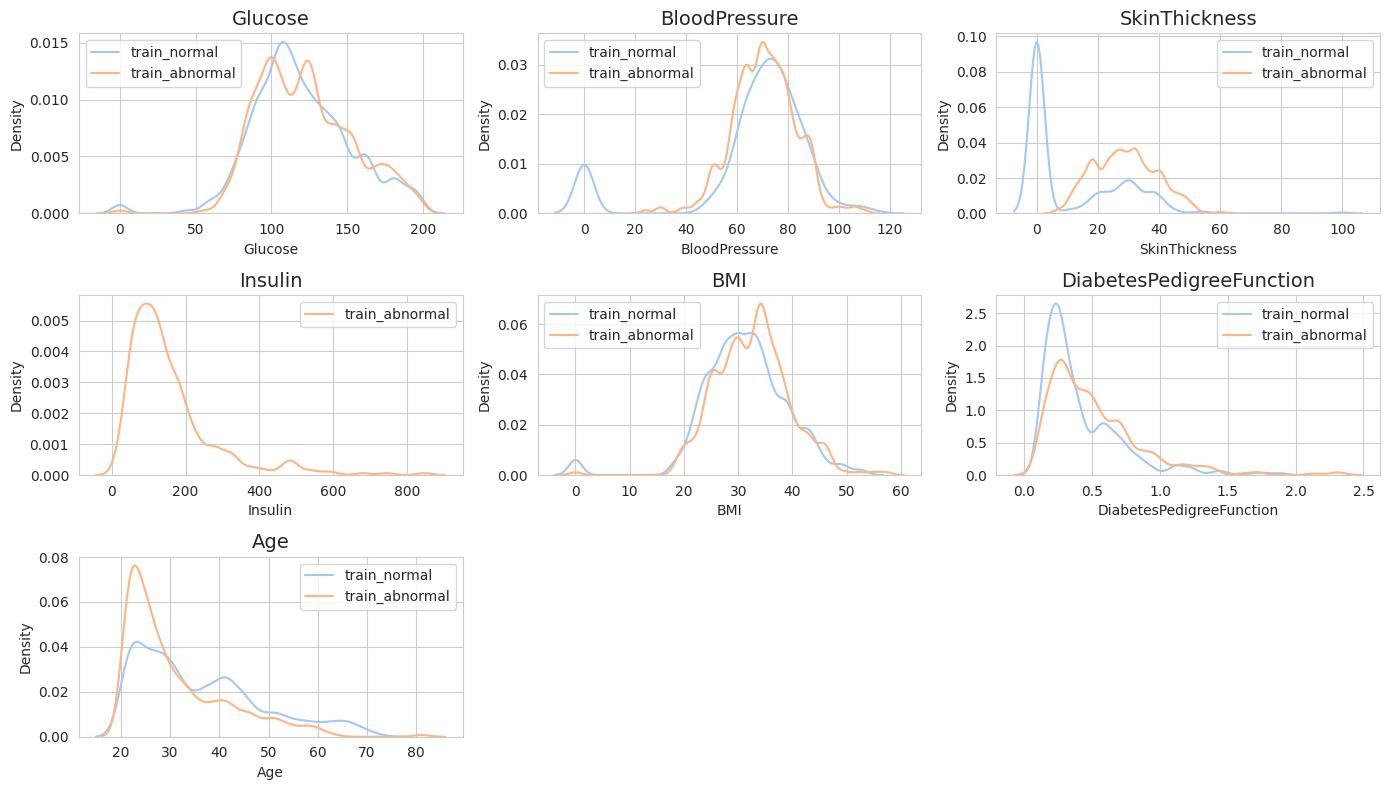

In [7]:
features_org = train.columns[1:-1]

# 특성들의 분포를 시각화하기 위한 함수
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure(figsize=(14,8))
    for feature in features:
        i += 1
        plt.subplot(3,3,i)
        sns.kdeplot(df1[feature], bw_adjust=0.5, label=label1)
        sns.kdeplot(df2[feature], bw_adjust=0.5, label=label2)
        plt.title(feature, fontsize=14)
        plt.legend()
    plt.tight_layout()
    plt.show()

# train_normal과 train_abnormal 데이터셋의 특성 분포 시각화
plot_feature_distribution(train_normal_insulin, train_missing_insulin, "train_normal", "train_abnormal", features_org)

In [8]:
from scipy.stats import shapiro

# Function to test normality using Shapiro-Wilk test
def test_normality(data):
    p_value = shapiro(data)[1]
    return p_value > 0.05  

features = train.columns[1:-1]

# Testing normality for each feature in both datasets
normality_results_normal = {feature: test_normality(train_normal_insulin[feature]) for feature in features}
normality_results_missing = {feature: test_normality(train_missing_insulin[feature]) for feature in features}
# Insulin 은 정규분포를 따르지않는다.
display(normality_results_normal)
display(normality_results_missing)

{'Glucose': False,
 'BloodPressure': False,
 'SkinThickness': False,
 'Insulin': True,
 'BMI': False,
 'DiabetesPedigreeFunction': False,
 'Age': False}

{'Glucose': False,
 'BloodPressure': False,
 'SkinThickness': False,
 'Insulin': False,
 'BMI': False,
 'DiabetesPedigreeFunction': False,
 'Age': False}

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# feature set 정의
features_org = list(train.columns)[1:-1]

#  train 데이터에서 Insulin이 0이 아닌 데이터 추출
train_normal = train.copy()
train_normal = train_normal.loc[train_normal['Insulin'] != 0]

train_normal_x = train_normal[features_org]
train_normal_y = train_normal['Outcome']

display(train_normal.head(5))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,4,103,60,33,192,24.0,0.966,33,0
3,1,119,88,41,170,45.3,0.507,26,0
4,1,114,66,36,200,38.1,0.289,21,0
5,3,78,50,32,88,31.0,0.248,26,1
6,1,91,54,25,100,25.2,0.234,23,0


In [10]:

test_normal =test.copy()

In [11]:
from scipy import stats
import numpy as np
features_org = train.columns[1:-1]
train_normal_x = train_normal[features_org]
test_normal_x = test_normal[features_org]
# Z-score 기반 이상치 제거
z_scores = np.abs(stats.zscore(train_normal_x))

z_scores2 = np.abs(stats.zscore(test_normal_x))

threshold = 3  # 이 값을 조절하여 이상치로 간주되는 임계점을 설정합니다.
train_zscore = train_normal_x.copy()[(z_scores < threshold).all(axis=1)]
train_zscore_y =train_normal.copy()[(z_scores < threshold).all(axis=1)].Outcome
# test_zscore = test_normal.copy()[(z_scores2 < threshold).all(axis=1)]

display(f"z_score 기반의 이상치 제거한 갯수 : {len(train_normal) - len(train_zscore)} 개, 비율 : {(len(train_normal) - len(train_zscore))/len(train_normal) * 100.0}")
# display(f"z_score 기반의 이상치 제거한 갯수 : {len(test_normal) - len(test_zscore)} 개, 비율 : {(len(test_normal) - len(test_zscore))/len(test_normal) * 100.0}")


'z_score 기반의 이상치 제거한 갯수 : 21 개, 비율 : 6.287425149700598'

In [12]:
from sklearn.model_selection import cross_val_score, cross_validate, KFold,StratifiedKFold

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)


train_normal_x = train_normal[features_org]
train_normal_y = train_normal['Outcome']

RF_model_normal = RandomForestClassifier(random_state = 42)

cv_result_normal = cross_validate(RF_model_normal, train_zscore[features_org], train_zscore_y, cv=kf, scoring=['accuracy', 'precision', 'recall', 'f1'])
df_cv_result_normal = pd.DataFrame(cv_result_normal, columns=['test_accuracy', 'test_precision', 'test_recall', 'test_f1'])

display(df_cv_result_normal)
display(df_cv_result_normal.describe().loc['mean',:].to_frame().T)

,test_accuracy,test_precision,test_recall,test_f1
0,0.746835,0.631579,0.480000,0.545455
1,0.794872,0.750000,0.500000,0.600000
2,0.820513,0.727273,0.666667,0.695652
3,0.782051,0.653846,0.680000,0.666667


,test_accuracy,test_precision,test_recall,test_f1
mean,0.786068,0.690674,0.581667,0.626943


,Feature,correlation_org,p_value_org
0,Glucose,0.490838,1.184780e-21
1,BloodPressure,0.187589,5.687410e-04
2,SkinThickness,0.255617,2.213224e-06
3,Insulin,0.318675,2.549956e-09
4,BMI,0.254424,2.476300e-06
5,DiabetesPedigreeFunction,0.200972,2.182284e-04
6,Age,0.335328,3.208500e-10


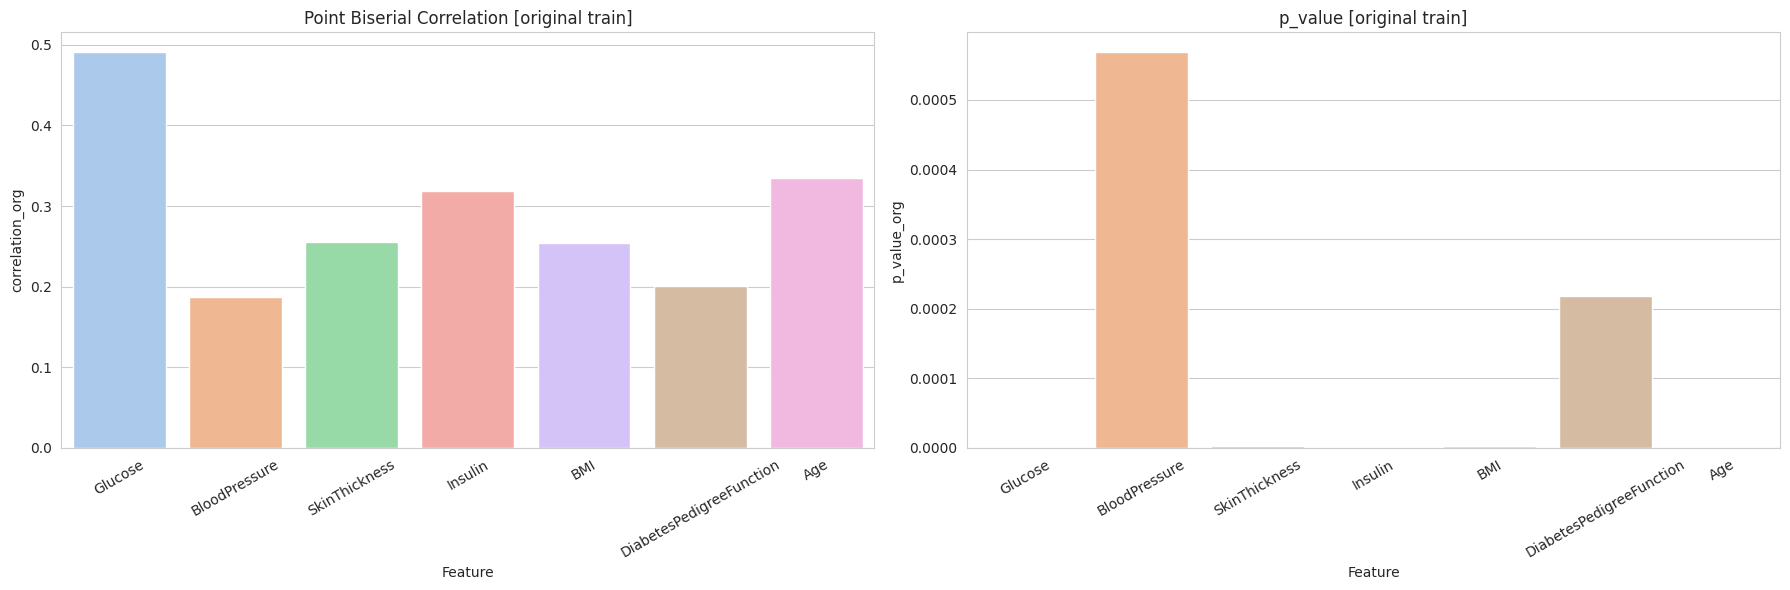

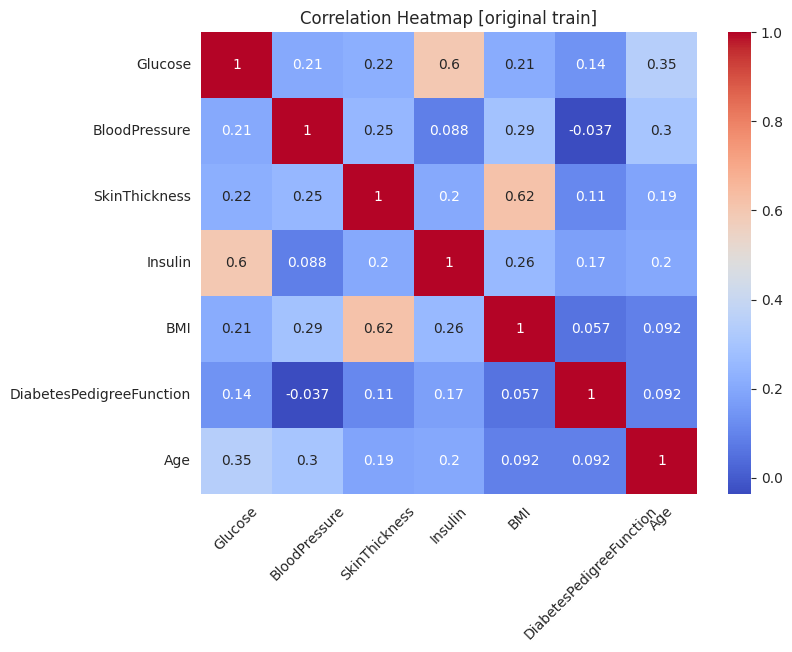

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pointbiserialr

# features_org 변수가 정의되어 있다고 가정합니다.
# train_normal 데이터프레임이 정의되어 있다고 가정합니다.

correlation_org_lst, p_value_org_lst = [], []

# 점 이연 상관계수 계산 및 출력
for feature in features_org:
    correlation_org, p_value_org = pointbiserialr(train_normal[feature], train_normal['Outcome'])
    correlation_org_lst.append(correlation_org)
    p_value_org_lst.append(p_value_org)

# 데이터프레임 생성
correlation_dict = {'Feature': features_org,
                    'correlation_org': correlation_org_lst,
                    'p_value_org' : p_value_org_lst }

correlation_df = pd.DataFrame(correlation_dict)

display(correlation_df)

plt.figure(figsize=(18, 6))

plt.subplot(1,2,1)
sns.barplot(x='Feature', y='correlation_org', data=correlation_df)
plt.title("Point Biserial Correlation [original train]")
plt.xticks(rotation=30)

plt.subplot(1,2,2)
sns.barplot(x='Feature', y='p_value_org', data=correlation_df)
plt.title("p_value [original train]")
plt.xticks(rotation=30)

plt.tight_layout()

plt.figure(figsize=(8, 6))
sns.heatmap(train_normal[features_org].corr(), cmap="coolwarm", annot=True)
plt.title("Correlation Heatmap [original train]")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [14]:
from sklearn.ensemble import RandomForestClassifier

# 피처 후보 생성
train_normal_try1 = train_normal.copy()

train_normal_try1['BloodPressure_BMI_Diff'] = train_normal_try1['BloodPressure'] -  train_normal_try1['BMI']
train_normal_try1['BloodPressure_BMI_Sum'] = train_normal_try1['BloodPressure'] + train_normal_try1['BMI']

train_normal_try1['BMI'] = train_normal_try1['BMI'].replace(0, train_normal_try1['BMI'].median())
train_normal_try1['BloodPressure_BMI_Ratio'] = train_normal_try1['BloodPressure'] / train_normal_try1['BMI']

train_normal_try1_x = train_normal_try1.drop('Outcome', axis=1)

features_to_evaluate = ['BloodPressure_BMI_Diff', 'BloodPressure_BMI_Sum', 'BloodPressure_BMI_Ratio']

rf_model = RandomForestClassifier(random_state = 42)

# 교차 검증 성능 비교
cv_scores = {}

for feature in features_to_evaluate:
    train_normal_add_x = train_normal[features_org].copy()
    train_normal_add_x[feature] = train_normal_try1[feature]
    scores = cross_val_score(rf_model, train_normal_add_x, train_normal_y, cv=kf, scoring='accuracy')
    cv_scores[feature] = scores.mean()

display(f"accuracy : {cv_scores}")

"accuracy : {'BloodPressure_BMI_Diff': 0.7544104991394148, 'BloodPressure_BMI_Sum': 0.784315834767642, 'BloodPressure_BMI_Ratio': 0.7783275960986805}"

In [15]:
train_zscore['BloodPressure_BMI_Sum'] = train_zscore['BloodPressure'] + train_zscore['BMI']
test_normal_x['BloodPressure_BMI_Sum'] = test_normal_x['BloodPressure'] + test_normal_x['BMI']
# train_zscore = train_zscore.drop('BloodPressure',axis=1)
# test_normal_x = test_normal_x.drop('BloodPressure',axis=1)


In [16]:

# 1. 모델 초기화
random_forest_model = RandomForestClassifier(n_estimators=400, # 트리의 개수
                                             random_state=42)  # 결과의 재현성을 위한 랜덤 시드 설정

# 2. 모델 학습
random_forest_model.fit(train_zscore, train_zscore_y)

# 3. 테스트 데이터에 대한 예측
y_pred = random_forest_model.predict(test_normal_x)

# # 4. 모델의 정확도 평가
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")



# 모델 예측
# Test set에서 예측을 수행하세요
# y_test = random_forest_model.predict(test_zscore_try2_x)
submit['Outcome'] = y_pred

submit.to_csv('last.csv', index = False)


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.preprocessing import LabelEncoder


# BloodPressure의 사분위수 계산
q1 = np.percentile(train_zscore['BloodPressure'], 25)
q2 = np.percentile(train_zscore['BloodPressure'], 50)
q3 = np.percentile(train_zscore['BloodPressure'], 75)
q4 = np.percentile(train_zscore['BloodPressure'], 100)

# BloodPressure를 2개의 범주로 나누기
q_BloodPressure_lst = [ 0, q1, q4]
BloodPressure_labels_train = pd.cut(train_zscore['BloodPressure'], bins = q_BloodPressure_lst, labels = ['q1', 'q2'])

# LabelEncoder로 범주형 데이터 인코딩
le_train_ = LabelEncoder()
train_zscore['BloodPressure_cat'] = le_train_.fit_transform(BloodPressure_labels_train)

# "BloodPressure_cat" 범주에 따른 "DiabetesPedigreeFunction"의 빈도수 계산
train_zscore['DiabetesPedigreeFunction_by_BloodPressure_cat'] = train_zscore.groupby('BloodPressure_cat')['DiabetesPedigreeFunction'].transform('count')

# BloodPressure_cat" 범주에 따른 "DiabetesPedigreeFunction"의 빈도수 dict형태로 backup
DPF_counts_by_BloodPressure_cat_train = train_zscore.groupby('BloodPressure_cat')['DiabetesPedigreeFunction'].count().to_dict()
display(DPF_counts_by_BloodPressure_cat_train)

# 피처가 추가된 데이터로 교차 검증 수행
train_zscore_x = train_zscore.drop(['BloodPressure_cat'], axis=1)

rf_model = RandomForestClassifier(random_state = 42)

# 결과 출력
cv_result_try = cross_val_score(rf_model, train_zscore_x, train_zscore_y, cv=kf, scoring='accuracy')
display(f"accuracy : { cv_result_try.mean()}")

display(train_zscore.head(5))



test_normal_x['BloodPressure_cat'] = le_train_.fit(BloodPressure_labels_train)
test_normal_x['DiabetesPedigreeFunction_by_BloodPressure_cat'] = test_normal_x.groupby('BloodPressure_cat')['DiabetesPedigreeFunction'].transform('count')

# BloodPressure_cat" 범주에 따른 "DiabetesPedigreeFunction"의 빈도수 dict형태로 backup
DPF_counts_by_BloodPressure_cat_test = test_normal_x.groupby('BloodPressure_cat')['DiabetesPedigreeFunction'].count().to_dict()
display(DPF_counts_by_BloodPressure_cat_test)
# 피처가 추가된 데이터로 교차 검증 수행
test_normal_x = test_normal_x.drop(['BloodPressure_cat'], axis=1)


{0: 101, 1: 212}

'accuracy : 0.7892323920804933'

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,BloodPressure_BMI_Sum,BloodPressure_cat,DiabetesPedigreeFunction_by_BloodPressure_cat
0,103,60,33,192,24.0,0.966,33,84.0,0,101
3,119,88,41,170,45.3,0.507,26,133.3,1,212
4,114,66,36,200,38.1,0.289,21,104.1,1,212
5,78,50,32,88,31.0,0.248,26,81.0,0,101
6,91,54,25,100,25.2,0.234,23,79.2,0,101


{LabelEncoder(): 116}

In [18]:

# 1. 모델 초기화
random_forest_model = RandomForestClassifier(n_estimators=400, # 트리의 개수
                                             random_state=42)  # 결과의 재현성을 위한 랜덤 시드 설정

# 2. 모델 학습
random_forest_model.fit(train_zscore_x, train_zscore_y)

# 3. 테스트 데이터에 대한 예측
# y_pred = random_forest_model.predict(X_test)

# # 4. 모델의 정확도 평가
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")



# 모델 예측
# Test set에서 예측을 수행하세요
y_test = random_forest_model.predict(test_normal_x)
submit['Outcome'] = y_test

submit.to_csv('last.csv', index = False)


In [19]:
train_normal_prep = train_normal.copy()
test_normal_prep = test_normal_x.copy()
train_normal_prep['BloodPressure_BMI_Sum'] = train_zscore_x['BloodPressure_BMI_Sum']
train_normal_prep['DiabetesPedigreeFunction_by_BloodPressure_cat'] = train_zscore_x['DiabetesPedigreeFunction_by_BloodPressure_cat']
test_normal_prep['BloodPressure_BMI_Sum'] = test_normal_x['BloodPressure_BMI_Sum']
test_normal_prep['DiabetesPedigreeFunction_by_BloodPressure_cat'] = test_normal_x['DiabetesPedigreeFunction_by_BloodPressure_cat']

# 점이연 상관 관계 유의성 없는 'BloodPressure', 'DiabetesPedigreeFunction' 제거
train_normal_prep = train_normal_prep.drop('BloodPressure', axis=1)
train_normal_prep = train_normal_prep.drop('DiabetesPedigreeFunction', axis=1)

train_normal_prep_x = train_normal_prep.drop(['Outcome'], axis=1)

test_normal_prep = test_normal_prep.drop('BloodPressure', axis=1)
test_normal_prep = test_normal_prep.drop('DiabetesPedigreeFunction', axis=1)

# RandomForestClassifier로 오버샘플링된 데이터에 대한 교차 검증
RF_model_prep = RandomForestClassifier(random_state=42)
cv_result_normal_prep = cross_validate(RF_model_prep, train_normal_prep_x, train_normal_y, cv=kf, scoring=['accuracy', 'precision', 'recall', 'f1'])
df_cv_result_normal_prep = pd.DataFrame(cv_result_normal_prep, columns=['test_accuracy', 'test_precision', 'test_recall', 'test_f1'])

display(df_cv_result_normal_prep)
display(df_cv_result_normal_prep.describe().loc['mean',:].to_frame().T)

display(train_normal_prep_x.head(5))

,test_accuracy,test_precision,test_recall,test_f1
0,0.821429,0.800000,0.592593,0.680851
1,0.821429,0.714286,0.740741,0.727273
2,0.783133,0.750000,0.461538,0.571429
3,0.759036,0.640000,0.592593,0.615385


,test_accuracy,test_precision,test_recall,test_f1
mean,0.796256,0.726071,0.596866,0.648734


,Pregnancies,Glucose,SkinThickness,Insulin,BMI,Age,BloodPressure_BMI_Sum,DiabetesPedigreeFunction_by_BloodPressure_cat
0,4,103,33,192,24.0,33,84.0,101.0
3,1,119,41,170,45.3,26,133.3,212.0
4,1,114,36,200,38.1,21,104.1,212.0
5,3,78,32,88,31.0,26,81.0,101.0
6,1,91,25,100,25.2,23,79.2,101.0


In [22]:

# 1. 모델 초기화
random_forest_model = RandomForestClassifier(n_estimators=400, # 트리의 개수
                                             random_state=42)  # 결과의 재현성을 위한 랜덤 시드 설정

# 2. 모델 학습
random_forest_model.fit(train_normal_prep_x.drop('Pregnancies',axis=1), train_normal_prep.Outcome)

# 3. 테스트 데이터에 대한 예측
# y_pred = random_forest_model.predict(X_test)

# # 4. 모델의 정확도 평가
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")



# 모델 예측
# Test set에서 예측을 수행하세요
y_test = random_forest_model.predict(test_normal_prep)
submit['Outcome'] = y_test

submit.to_csv('last.csv', index = False)
